# Write and test functions for making bifurcation diagrams

Functions:


In [86]:
#%%writefile bif_diagram_funs.py
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, 'Functions')
#from scipy.optimize import root
from fitness_funs_non_dim import *
from group_w_pop_funs import *
from local_stability_funs import *
from equilibria_funs import *
from sim_graph_funs import *
from matplotlib.lines import Line2D

param_lab_dic = dict(η1 = "Growth of big prey, " + r'$\eta_1$', 
            η2 = "Growth of small prey, " + r'$\eta_1$', 
            A = "Relative attack rates, " + r'$A$', 
            β1 = "Benefit of big prey, " + r'$\beta_1$',
            β2 = "Benefit of small prey, " + r'$\beta_1$', 
            H1= "Handling time of big prey, " + r'$H_1$', 
            H2= "Handling time of small prey," + r'$H_2$', 
            α1_of_1= "Capture probability of big prey\nby solitary predator, " + r'$\alpha_1(1)$',
            α2_of_1="Capture probability of small prey\nby solitary predator, " + r'$\alpha_2(1)$', 
            s1="Critical group size for big prey, " + r'$s_1$', 
            s2="Critical group size for small prey, " + r'$s_2$', 
            α2_fun_type = 'Shape of capture probability for small prey',
            x_max = 'Max group size, ' + r'$x_{max}$',
            d = "Decision accuracy, " + r'$d$',
            Tx = "Timescale of group dynamics, " + r'$T_x$',
            scale = "Prey size ratio, " + r'$\beta_1/\beta_2$')


    

def get_perturbations(equilibrium, num, strength):
    '''
    Generate perturbed versions of a given equilibrium.

    Args:
        equilibrium (array): The equilibrium point to perturb. [N1, N2, g(1), g(2), ..., g(xmax)]
        num (int): Number of perturbed points to generate.
        strength (float): Perturbation strength.

    Returns:
        np.ndarray: Array of perturbed points.
    '''
    #  initiate empty array
    perturbations = np.zeros((num, equilibrium.shape[0]))
    # fill array
    for i in range(0,num):
        #perturb
        curr_perturbed = equilibrium + strength * np.random.standard_normal(len(equilibrium))
        curr_perturbed[0:2] = np.clip(curr_perturbed[0:2], 1e-4, 1-1e-4) # make sure 0<N1,N2 <1
        curr_perturbed[2:] = np.clip(curr_perturbed[2:], a_min = 1e-8, a_max = None)
        perturbations[i,:] = curr_perturbed
    return perturbations

    # returns "Stable (attractive)", "Unstable", "Marginally stable (needs further analysis)"
    # and "Indeterminate stability (needs further analysis)"


    

def initiate_equilibria_dataframe(param_key, x_max):
    # Define the column names
    columns = [param_key, 'N1', 'N2'] + \
              [f'g{i}' for i in range(1, x_max + 1)] + \
              ['mean_x', 'var', 'equilibrium_type', 'stability']
    
    # Initialize the DataFrame with specific dtypes
    dtype_dict = {col: 'float64' for col in columns[:-2]}  # All numeric columns
    dtype_dict.update({'equilibrium_type': 'object', 'stability': 'object'})  # Categorical columns
    
    df = pd.DataFrame(columns=columns).astype(dtype_dict)  # Set explicit dtypes
    return df

def get_coexistence_equilibria(param_key, param_vec, num_init=10,
                               num_perturbations=2, perturb_strength=0.01, t_f=1100,
                               **params_base):
    '''
    Get equilibria using N1 >0, N2 > 0 nullclines.
    '''
    # Initiate empty perturbed_pts array
    perturbed_pts = np.array([]).reshape(0, 2 + params_base['x_max'])
    
    # Initiate an empty dataframe to store points
    x_max = params_base['x_max']
    df = initiate_equilibria_dataframe(param_key, x_max)

    # Collect rows to append later
    rows = []

    # Get random initial points
    init_pts0 = get_initial_points(num_initial=num_init, **params_base.copy())
    
    for param in param_vec:
        # Update param dictionary
        params = update_params(param_key, param, params_base)
        
        # Add perturbed_pts to init_pts
        init_pts = np.vstack((init_pts0, perturbed_pts))

        # Use init_pts to get equilibria in which N1, N2 > 0
        coexist_equilibria = get_equilibria_from_init_pts(
            init_pts, tol_unique=1e-8, **params.copy(), if_dict=True
        )
    
        # Iterate if no points found using solver
        if np.size(coexist_equilibria) == 0:
            initialstate = np.array([.7, .7, *initiate_g_first_x(3, params["x_max"])])
            coexist_eq, success, _ = iterate_to_eq(initialstate, t_f, params)
            coexist_equilibria = [coexist_eq] if success else []

        # Classify stability and store equilibria
        if np.size(coexist_equilibria) > 0:
            for eq_dic in coexist_equilibria:
                equilibrium = eq_dic['equilibrium']
                perturbed_pts = get_perturbations(equilibrium, 
                                                  num_perturbations, perturb_strength)
                stability = classify_equilibrium(equilibrium, params)
                
                # Prepare row for DataFrame
                row = [param, *equilibrium, eq_dic['mean_x'], eq_dic['var'],
                       'Coexistence', stability]
                rows.append(row)

    # Append all rows at once to the DataFrame
    if rows:
        new_df = pd.DataFrame(rows, columns=df.columns)
        df = pd.concat([df, new_df], ignore_index=True)
    
    return df




def plot_equilibria(axN1, axN2, axx, axNsum, axvar, 
                    equilibria, markers, color, label2 = ""):
    '''
    Plot equilibria on axes for N1, N2, mean group size, and total prey density.

    Args:
        axN1, axN2, axx, axNsum (Axes): Axes for plotting.
        equilibria (array): Array of equilibria. 
                            where first entry is corresponding parameter 
                            that's being varied
        markers (dict): Marker properties for the scatter plot.
        color (str): Color for the points.
        label2 (str): Additional label for the legend.

    Returns:
        tuple: Updated axes.
    '''
    markers = markers.copy()
    markers["color"] = color
    markers["label"] = markers["label"] + label2
    if equilibria.size > 0:
        # TO-DO: make these access a df
        paramvec = equilibria[:,0]
        N1 = np.array(equilibria[:,1])
        N2 = np.array(equilibria[:,2])
        meanx = equilibria[:,-1]
        
        axN1.scatter(paramvec, N1, **markers)
        axN2.scatter(paramvec, N2, **markers)
        axx.scatter(paramvec, meanx, **markers)
        axNsum.scatter(paramvec, N1+N2, **markers)
        # TO-DO
        # axvar.scatter(paramvec, var, **markers)
    return axN1, axN2, axx, axNsum, axvar
    
def plot_bif_diagram2(param_key, param_vec, params_base, num_init = 30, 
                      num_perturbations = 2,
                          perturb_strength = 0.01,t_f = 1100):
    '''
    Generate and plot a bifurcation diagram for the system.
    Dependencies:
        get_coexistence_equilibria
        plot_equilibria
        get_predator_extinct_equilibria
        get_prey_extinct_equilibria
        format_bif_diagrams
    Args:
        param_key (str): Parameter to vary.
        param_vec (array): Values of the parameter to iterate over.
        params_base (dict): Base system parameters.
        num_init (int): Number of random initial points to generate.
        num_perturbations (int): Number of perturbations to generate.
        perturb_strength (float): Perturbation strength.
        t_f (float): Simulation end time.

    Returns:
        tuple: 4 Figures for various bifurcation diagrams, 1 figure with just the legend
    '''
    figx, axx = plt.subplots(1,1)
    figN1, axN1 = plt.subplots(1,1)
    figN2, axN2 = plt.subplots(1,1)
    figNsum, axNsum = plt.subplots(1,1)
    figlegend, axlegend = plt.subplots(1,1)
    figvar, axvar = plt.subplots(1,1)

    stable_markers = dict(label = "Stable ", marker = "o", s = 5)
    unstable_markers = dict(label = "Unstable ", marker = 'D', 
                            s = 30, facecolors='none')
    
    # get coexistence equilibria
    df = get_coexistence_equilibria(
        param_key, param_vec,
        num_init, num_perturbations, perturb_strength, t_f = t_f,
        **params_base)
    # sp, usp = get_coexistence_equilibria(
    #     param_key, param_vec,
    #     num_init, num_perturbations, perturb_strength, t_f = t_f,
    #     **params_base)
    # label2 = "coexist"
    # axes = plot_equilibria(
    #     axN1, axN2, axx, axNsum, axvar,
    #                 sp, stable_markers, 'k', label2 = label2)
    # axes = plot_equilibria(*axes, usp, unstable_markers,'k', 
    #                        label2 = label2)


    # # plot predator extinction equilibria - blue
    # label2 = "Predators Extinct"#'$p^*=0$'
    # sp, usp = get_predator_extinct_equilibria(param_key, param_vec, params_base) 
    # axes = plot_equilibria(*axes, sp, stable_markers,'b', label2 = label2)
    # axes = plot_equilibria(*axes, usp, unstable_markers,'b', label2)

    # # plot prey 1 and 2 extinction equilibria - red and cyan, respectively
    # prey_colors = ['red', 'cyan']
    # N_legend_labs = ["Big Prey Extinct", "Small Prey Extinct"]#[r'$N^*_1=0$', r'$N^*_2=0$']
    # for i in [1,2]:
    #     sp, usp = get_prey_extinct_equilibria(
    #         param_key, param_vec,i, num_init, num_perturbations,
    #         perturb_strength,**params_base
    #     )
    #     c = prey_colors[i-1]
    #     label2 = N_legend_labs[i-1]
    #     axes = plot_equilibria(*axes, sp, stable_markers,c,
    #                           label2 = label2)
    #     axes = plot_equilibria(*axes, usp, unstable_markers,c,
    #                           label2 = label2)
    format_bif_diagrams(axx, axN1, axN2, axNsum, axvar, axlegend, param_key)
    return figx, figN1, figN2, figNsum, figvar, figlegend

def format_bif_diagrams(axx, axN1, axN2, axNsum, axvar, axlegend, param_key):
    '''
    Format bifurcation diagram axes and add a legend.

    Args:
        axx, axN1, axN2, axNsum (Axes): Axes for plotting.
        axlegend (Axes): Axis for the legend.
        param_key (str): Parameter used for the x-axis.

    Returns:
        None
    '''
    param_lab_dic = dict(η1 = "Growth of big prey, " + r'$\eta_1$', 
                η2 = "Growth of small prey, " + r'$\eta_1$', 
                A = "Relative attack rates, " + r'$A$', 
                β1 = "Benefit of big prey, " + r'$\beta_1$',
                β2 = "Benefit of small prey, " + r'$\beta_1$', 
                H1= "Handling time of big prey, " + r'$H_1$', 
                H2= "Handling time of small prey," + r'$H_2$', 
                α1_of_1= "Capture probability of big prey\nby solitary predator, " + r'$\alpha_1(1)$',
                α2_of_1="Capture probability of small prey\nby solitary predator, " + r'$\alpha_2(1)$', 
                s1="Critical group size for big prey, " + r'$s_1$', 
                s2="Critical group size for small prey, " + r'$s_2$', 
                α2_fun_type = 'Shape of capture probability for small prey',
                x_max = 'Max group size, ' + r'$x_{max}$',
                d = "Decision accuracy, " + r'$d$',
                Tx = "Timescale of group dynamics, " + r'$T_x$',
                scale = "Prey size ratio, " + r'$\beta_1/\beta_2$')
    
    Nsumlab = "Sum of Prey Densities,\n "+r'$N_1 + N_2$'
    for ax, ylab in zip([axx, axN1, axN2, axNsum, axvar],
                        [mean_x_lab, N1lab, N2lab,
                        Nsumlab, standard_labs['var']]):
        xlab = param_lab_dic[param_key]
        format_ax(ax,xlab,ylab, xlim = None, ylim=None,
              fs_labs = 20, if_legend = False)

    # add legend
    stable_markers = dict(marker = "o", markersize = 3, linestyle = '')
    unstable_markers = dict(marker = 'D', color='none',markersize=6, linestyle='')
    
    legend_handles = [
        # Stable (dots)
        Line2D([0], [0], **stable_markers, color='black', label='Stable, Coexist'),
        Line2D([0], [0], **stable_markers, color='blue', label='Stable, Predator Extinct'),
        Line2D([0], [0], **stable_markers, color='red', label='Stable, Prey 1 Extinct'),
        Line2D([0], [0], **stable_markers, color='cyan', label='Stable, Prey 2 Extinct'),
    
        # Unstable (unfilled diamonds)
        Line2D([0], [0],  **unstable_markers, markeredgecolor='black', label='Unstable, Coexist'),
        Line2D([0], [0], **unstable_markers, markeredgecolor='blue', label='Unstable, Predator Extinct'),
        Line2D([0], [0], **unstable_markers, markeredgecolor='red', label='Unstable, Prey 1 Extinct'),
        Line2D([0], [0], **unstable_markers, markeredgecolor='cyan', label='Unstable, Prey 2 Extinct'),
    ]
    axlegend.axis('off') 
    axlegend.legend(handles = legend_handles, loc='center', ncol = 1,
                   fontsize = 20)

#### retired or not used anymore
def check_unique(results, new_eq_dic, tol_unique = 1e-8):
    '''
    Check if a new equilibrium is unique and append it to the results if it is.

    Args:
        results (list): List of dictionaries of existing equilibria.
        new_eq_dic (dict): New equilibrium to check.
        tol_unique (float): Tolerance for determining uniqueness.

    Returns:
        list: Updated results with the new equilibrium appended if unique.
    '''
    if len(results)>0:
        for result in results:
            if np.any(np.abs(new_eq_dic['equilibrium'] - result['equilibrium']) > tol_unique):
                results.append(new_eq_dic)
    else:
        results.append(new_eq_dic)
    return results

In [34]:
import pandas as pd

def store_equilibria_in_dataframe(param, equilibria, stability, equilibrium_type, x_max):
    '''
    Store equilibrium points in a pandas DataFrame.

    Args:
        param (float): Parameter value.
        equilibria (list of lists): List of equilibrium points, where each is of form [N1, N2, g1, ..., g(x_max), mean_x].
        stability (str): Stability of the equilibrium ('Stable' or 'Unstable').
        equilibrium_type (str): Type of equilibrium ('Coexistence', 'Predators Extinct', 'Big Prey Extinct', 'Small Prey Extinct').
        x_max (int): Maximum group size.

    Returns:
        pd.DataFrame: DataFrame with columns for all equilibrium properties and plotting attributes.
    '''
    # Create column names dynamically based on x_max
    columns = ['param', 'N1', 'N2'] + [f'g{i}' for i in range(1, x_max + 1)] + ['mean_x', 'equilibrium_type', 'stability']

    # Add additional columns for plotting
    columns += ['marker', 'color']

    # Prepare data rows
    rows = []
    for eq in equilibria:
        # Set marker and color based on equilibrium_type and stability
        if equilibrium_type == 'Coexistence':
            color = 'black'
        elif equilibrium_type == 'Predators Extinct':
            color = 'blue'
        elif equilibrium_type == 'Big Prey Extinct':
            color = 'red'
        elif equilibrium_type == 'Small Prey Extinct':
            color = 'cyan'
        else:
            color = 'gray'

        marker = 'o' if stability == 'Stable' else 'D'

        # Create the row
        row = [param, *eq, equilibrium_type, stability, marker, color]
        rows.append(row)

    # Create and return the DataFrame
    return pd.DataFrame(rows, columns=columns)

def plot_equilibria_from_dataframe(df, ax, x_col, y_col):
    '''
    Scatter plot equilibria from a pandas DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing equilibrium information and plotting attributes.
        ax (matplotlib.axes.Axes): Matplotlib axis to plot on.
        x_col (str): Column name for x-axis data.
        y_col (str): Column name for y-axis data.

    Returns:
        ax: Updated axis with the plot.
    '''
    # Group by marker and color
    for (marker, color), group in df.groupby(['marker', 'color']):
        ax.scatter(
            group[x_col], group[y_col],
            label=f"{group['equilibrium_type'].iloc[0]} - {group['stability'].iloc[0]}",
            marker=marker, color=color, s=30, edgecolors='black' if marker == 'D' else None
        )
    return ax


# Add in Variance and use dataframes check

In [87]:
H = 0
x_max = 5
params_base = dict(η1 = 0.2, η2 = 0.5, A = 0.5, β1 = 8, β2 = 1, H1=H, H2=H, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'constant',
                  x_max = x_max, d = 10,
                 Tx = .01, pop_process = True)

In [84]:
param_vec = np.linspace(0.01,params_base['η2'],30)
param_key = 'η1'
num_init = 10
num_perturbations = 2
perturb_strength = 0.01




In [85]:
get_coexistence_equilibria(param_key, param_vec, 
                          **params_base)

/Users/taliaborofsky/Documents/CH_GroupFormation/CH_code/Functions/group_w_pop_funs.py:373: RuntimeWarning: invalid value encountered in divide
  u_ = y_/(b*y0)


,η1,N1,N2,g1,g2,g3,g4,g5,mean_x,var,equilibrium_type,stability
0,0.010000,0.324688,0.872645,0.120888,0.011225,0.001916,0.000029,1.244873e-07,1.229852,0.258735,Coexistence,Stable (attractive)
1,0.026897,0.324422,0.798160,0.168058,0.031696,0.012346,0.000360,1.999122e-06,1.525426,0.556251,Coexistence,Stable (attractive)
2,0.026897,0.324422,0.798160,0.168058,0.031696,0.012346,0.000360,1.999122e-06,1.525426,0.556251,Coexistence,Stable (attractive)
3,0.026897,0.324422,0.798160,0.168058,0.031696,0.012346,0.000360,1.999090e-06,1.525426,0.556251,Coexistence,Stable (attractive)
4,0.043793,0.313262,0.744452,0.192839,0.048651,0.026463,0.001038,6.548819e-06,1.718903,0.694644,Coexistence,Stable (attractive)
...,...,...,...,...,...,...,...,...,...,...,...,...
244,0.466207,0.025907,0.031299,0.045097,0.078662,0.567768,0.312718,1.544061e-02,3.358019,0.458562,Coexistence,Stable (attractive)
245,0.466207,0.025907,0.031299,0.045097,0.078662,0.567768,0.312718,1.544061e-02,3.358019,0.458562,Coexistence,Stable (attractive)
246,0.483103,0.013358,0.014334,0.028509,0.058153,0.540277,0.385940,2.466467e-02,3.471078,0.438608,Coexistence,Stable (attractive)
247,0.483103,0.013358,0.014334,0.028509,0.058153,0.540277,0.385940,2.466467e-02,3.471078,0.438608,Coexistence,Stable (attractive)


/Users/taliaborofsky/Documents/CH_GroupFormation/CH_code/Functions/group_w_pop_funs.py:373: RuntimeWarning: invalid value encountered in divide
  u_ = y_/(b*y0)


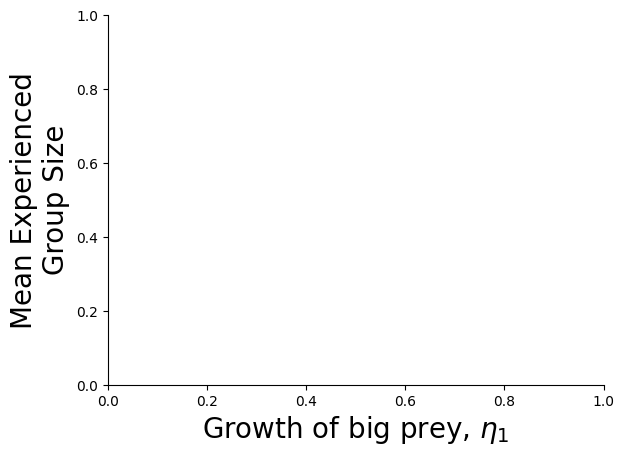

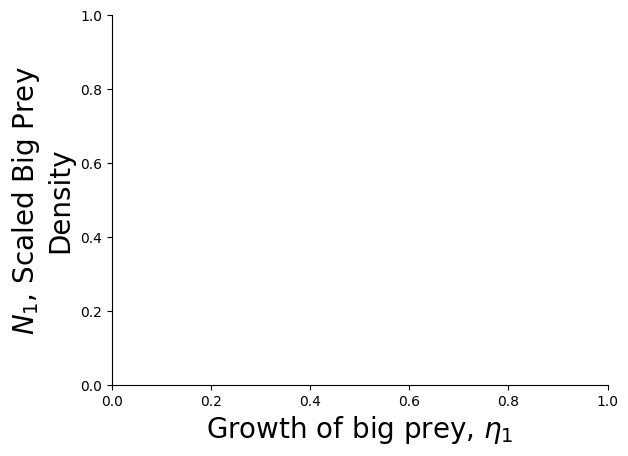

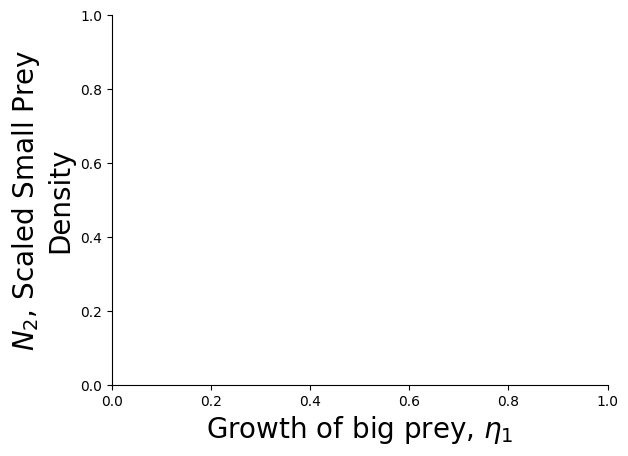

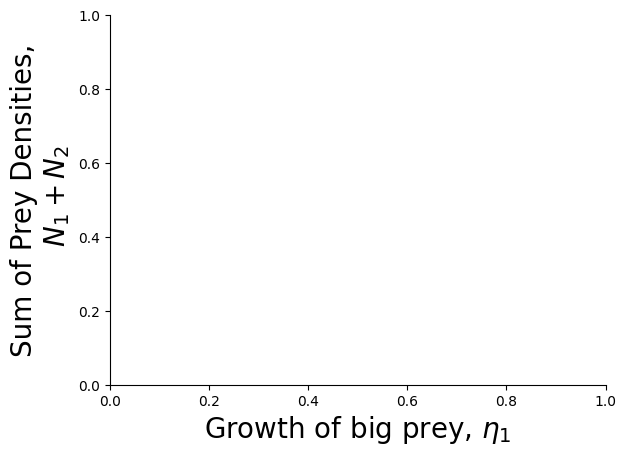

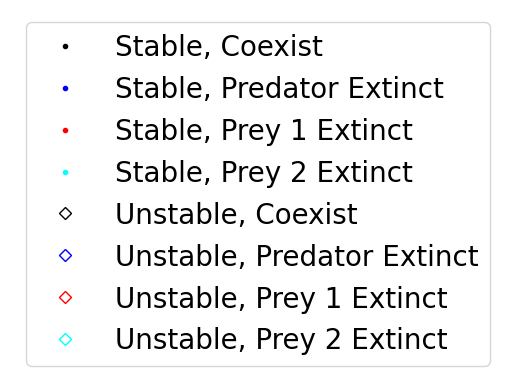

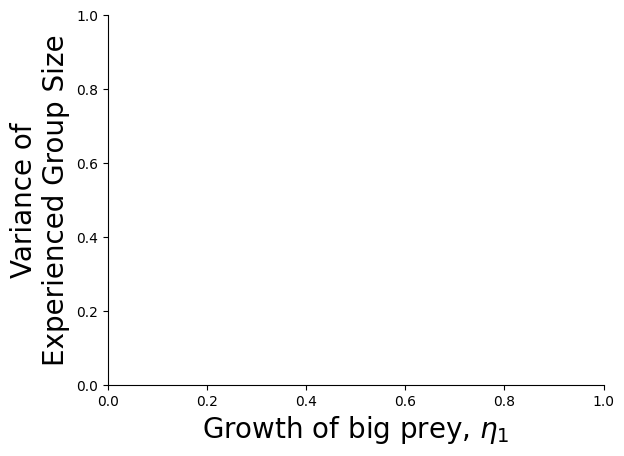

In [88]:
param_vec = np.linspace(0.01,params_base['η2'],30)
figx, figN1, figN2, figNsum, figvar, figlegend = plot_bif_diagram2(
    param_key = 'η1', 
    param_vec = param_vec, 
    params_base = params_base,
    num_init = 10, 
                      num_perturbations = 2,
                          perturb_strength = 0.01)

# Figure out Legends

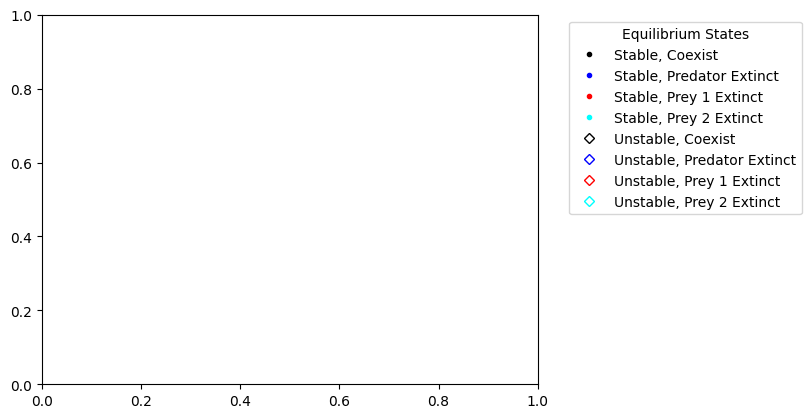

In [13]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
color_map = ['k','b','r','cyan']

stable_markers = dict(marker = "o", markersize = 3, linestyle = '')
unstable_markers = dict(marker = 'D', color='none',markersize=5, linestyle='')

legend_handles = [
    # Stable (dots)
    Line2D([0], [0], **stable_markers, color='black', label='Stable, Coexist'),
    Line2D([0], [0], **stable_markers, color='blue', label='Stable, Predator Extinct'),
    Line2D([0], [0], **stable_markers, color='red', label='Stable, Prey 1 Extinct'),
    Line2D([0], [0], **stable_markers, color='cyan', label='Stable, Prey 2 Extinct'),

    # Unstable (unfilled diamonds)
    Line2D([0], [0],  **unstable_markers, markeredgecolor='black', label='Unstable, Coexist'),
    Line2D([0], [0], **unstable_markers, markeredgecolor='blue', label='Unstable, Predator Extinct'),
    Line2D([0], [0], **unstable_markers, markeredgecolor='red', label='Unstable, Prey 1 Extinct'),
    Line2D([0], [0], **unstable_markers, markeredgecolor='cyan', label='Unstable, Prey 2 Extinct'),
]
plt.legend(handles=legend_handles, title="Equilibrium States", bbox_to_anchor=(1.05, 1), loc='upper left')


# Test Type 1, Vary Prey Growth

In [23]:
sp, usp = get_coexistence_equilibria(
    371     param_key, param_vec,
    372     num_init, num_perturbations, perturb_strength, t_f = t_f,
    373     **params_base)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (445400184.py, line 2)

In [9]:
H = 0
x_max = 5
params_base = dict(η1 = 0.2, η2 = 0.5, A = 0.5, β1 = 8, β2 = 1, H1=H, H2=H, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'constant',
                  x_max = x_max, d = 10,
                 Tx = .01, pop_process = True)

In [5]:
t_f = 1100
weird_params = {'η1': np.float64(0.5), 'η2': 0.5, 'A': 0.5, 'β1': 8, 'β2': 1, 'H1': 0, 'H2': 0, 'α1_of_1': 0.05, 'α2_of_1': 0.95, 's1': 2, 's2': 2, 'α2_fun_type': 'constant', 
 'x_max': 5, 'd': 10, 'Tx': 0.01, 'pop_process': True}
initialstate = np.array([.7,.7,*initiate_g_first_x(3,weird_params["x_max"])])
coexist_eq, success, _ = iterate_to_eq(initialstate, t_f, weird_params)
coexist_eq = np.array(coexist_eq)

/Users/taliaborofsky/Documents/CH_GroupFormation/CH_code/Functions/group_w_pop_funs.py:373: RuntimeWarning: invalid value encountered in divide
  u_ = y_/(b*y0)


In [13]:
initialstate

array([7.e-01, 7.e-01, 1.e+00, 1.e+00, 1.e+00, 1.e-04, 1.e-04])

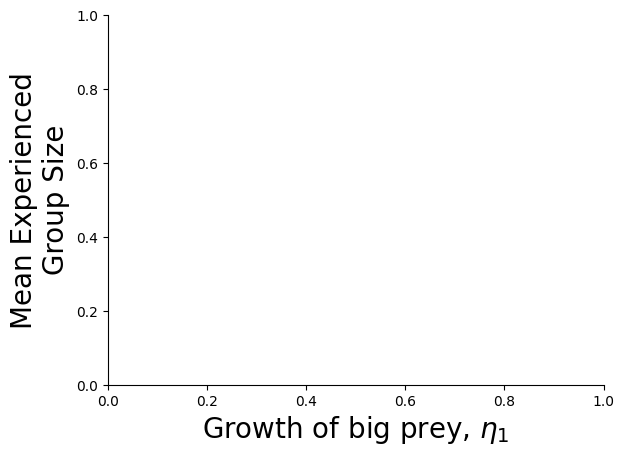

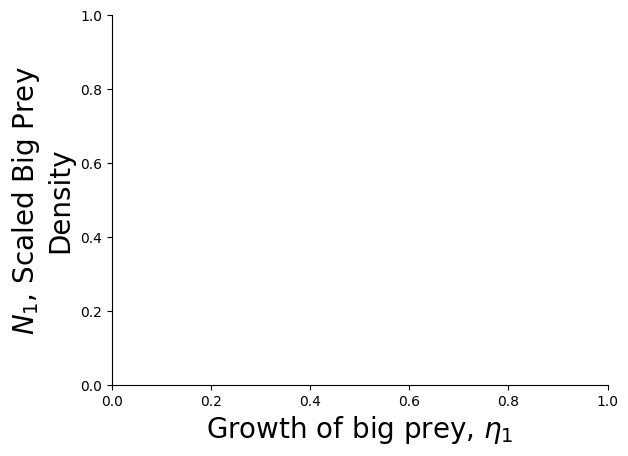

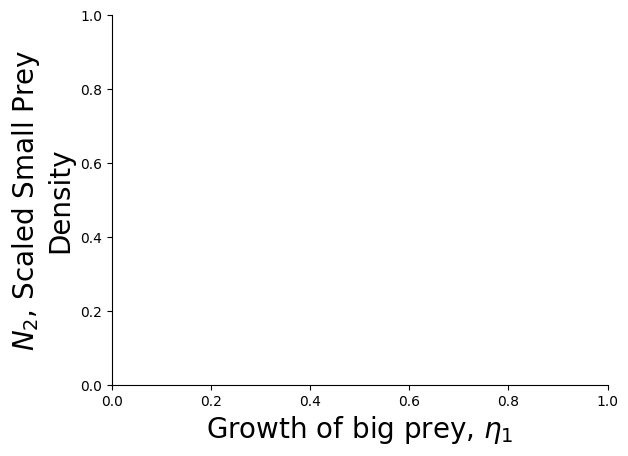

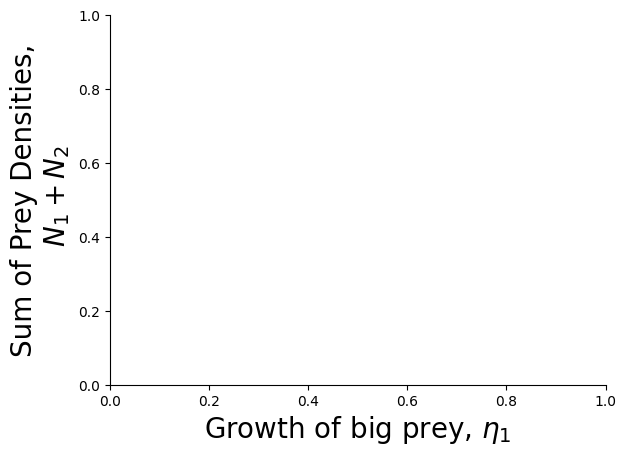

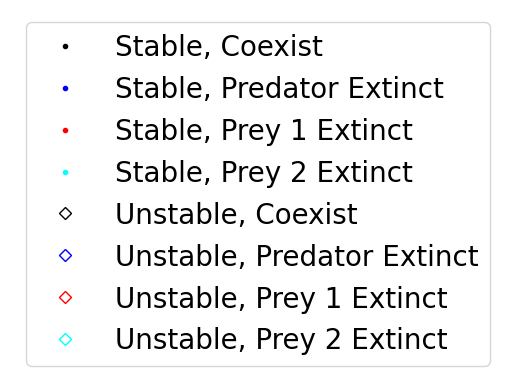

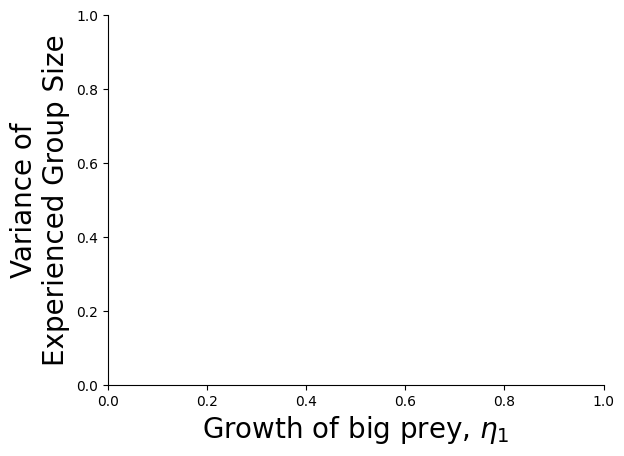

In [12]:
param_vec = np.linspace(0.01,params_base['η2'],30)
figx, figN1, figN2, figNsum, figvar, figlegend = plot_bif_diagram2(
    param_key = 'η1', 
    param_vec = param_vec, 
    params_base = params_base,
    num_init = 10, 
                      num_perturbations = 4,
                          perturb_strength = 0.02)

# Test Type II, with scale parameter

In [22]:
H = 1
x_max = 5
params_base = dict(η1 = 0.2, η2 = 0.5, A = 0.5, β1 = 8, β2 = 1, H1=H, H2=H, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'constant',
                  x_max = x_max, d = 10,
                 Tx = .01, pop_process = True)

In [23]:
param_key = "scale"
param = 12
params = update_params(param_key,param,params_base)
t_f = 1100

initialstate = [.7,.7,*initiate_g_first_x(3,params["x_max"])]
coexist_eq, success, _ = iterate_to_eq(initialstate, t_f, params)
coexist_eq = np.array(coexist_eq)


In [24]:
classify_and_store_equilibrium(
coexist_eq, stable_points, unstable_points, param, params
)

([],
 [[12,
   np.float64(0.42623566659864504),
   np.float64(0.643504472733688),
   np.float64(0.20980322035052312),
   np.float64(0.1722060365211732),
   np.float64(0.3096198689767072),
   np.float64(0.17497660370168425),
   np.float64(0.03116666905009455),
   np.float64(3.105846177449584)],
  [12,
   np.float64(0.42623566659864504),
   np.float64(0.643504472733688),
   np.float64(0.20980322035052312),
   np.float64(0.1722060365211732),
   np.float64(0.3096198689767072),
   np.float64(0.17497660370168425),
   np.float64(0.03116666905009455),
   np.float64(3.105846177449584)]])

In [26]:
stable_points = []; unstable_points = []
num_perturbations = 2; perturb_strength = .01
store_equilibria_and_perturb(
    param, [coexist_eq], stable_points, unstable_points,
    params, num_perturbations,
    perturb_strength
    )

([],
 [[12,
   np.float64(0.42623566659864504),
   np.float64(0.643504472733688),
   np.float64(0.20980322035052312),
   np.float64(0.1722060365211732),
   np.float64(0.3096198689767072),
   np.float64(0.17497660370168425),
   np.float64(0.03116666905009455),
   np.float64(3.105846177449584)]],
 array([[0.43159956, 0.626793  , 0.2014196 , 0.16007947, 0.31743929,
         0.1743225 , 0.03103164],
        [0.41516834, 0.64050754, 0.20216857, 0.17604059, 0.29970896,
         0.18827455, 0.01441086]]))

In [ ]:
initialstate = [.7,.7,*initiate_g_first_x(3,params["x_max"])]
params = params_base.copy()
coexist_eq, success, _ = iterate_to_eq(initialstate, t_f, params)
coexist_eq = np.array(coexist_eq)
if success:
try:
    out = store_equilibria_and_perturb(
    param, coexist_eq, stable_points, unstable_points,
    params, num_perturbations,
    perturb_strength
    )

(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>)

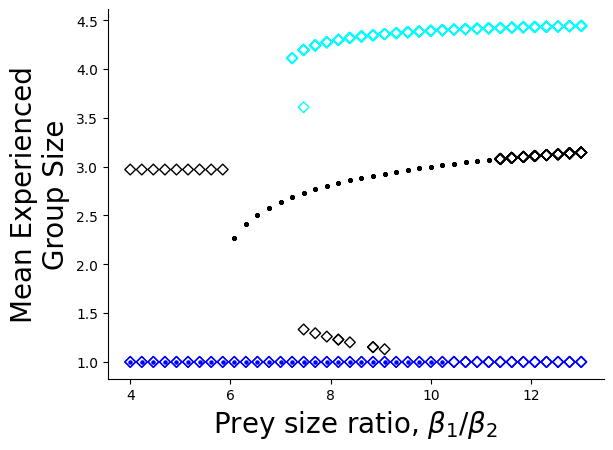

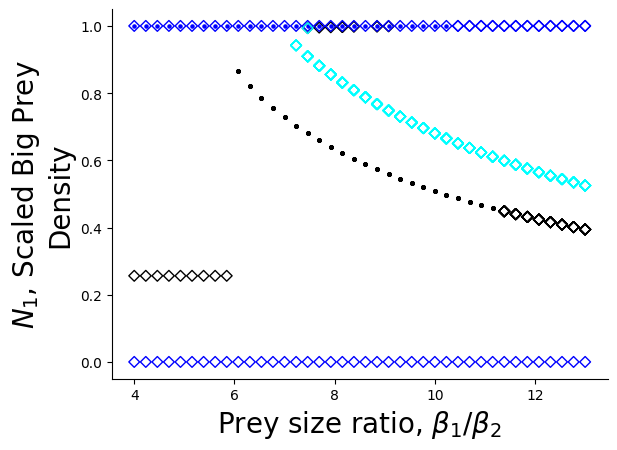

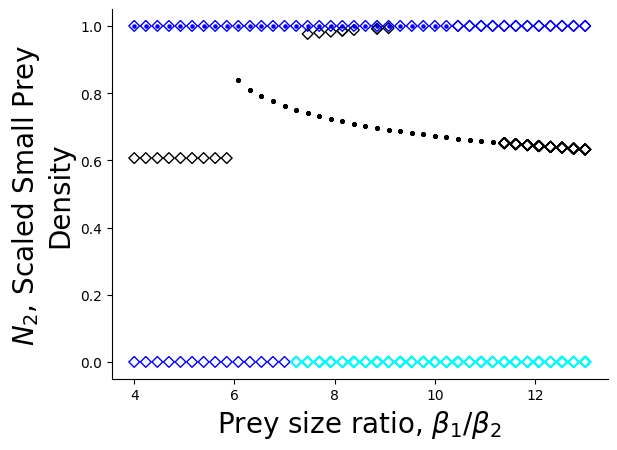

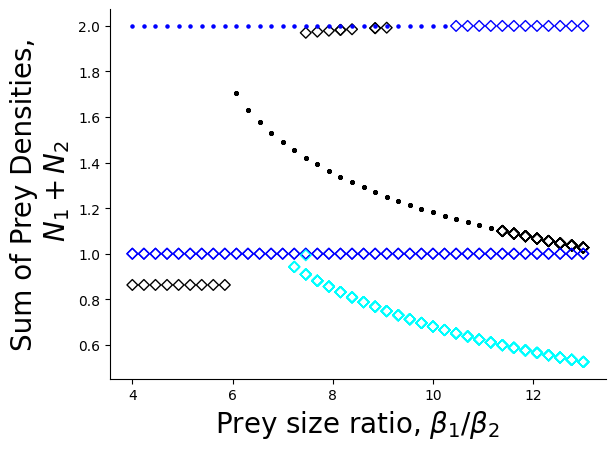

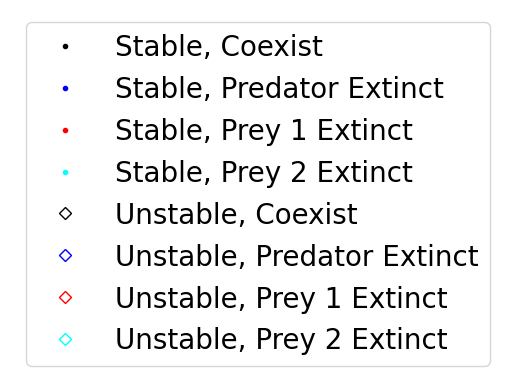

In [27]:
plot_bif_diagram2(
    param_key = "scale", param_vec = np.linspace(4,13,40), params_base = params_base,
    num_init = 10, 
                      num_perturbations = 4,
                          perturb_strength = 0.02)

In [52]:
stable_points, unstable_points = get_bif_diagram_input('scale', np.linspace(1.1,12,60),  
                          **params_base, num_init = 20, num_perturbations=3)#num_init = 10, num_perturbations=2)


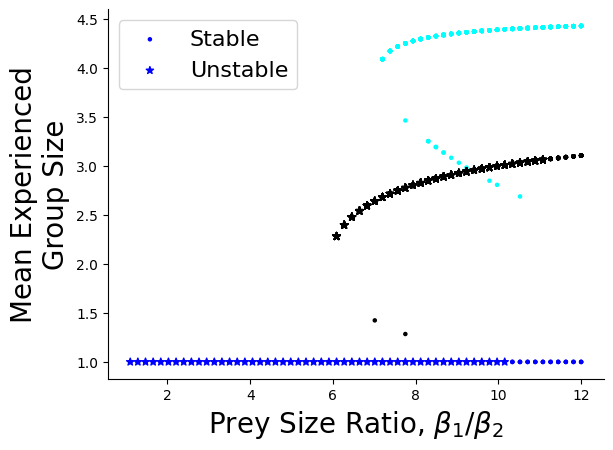

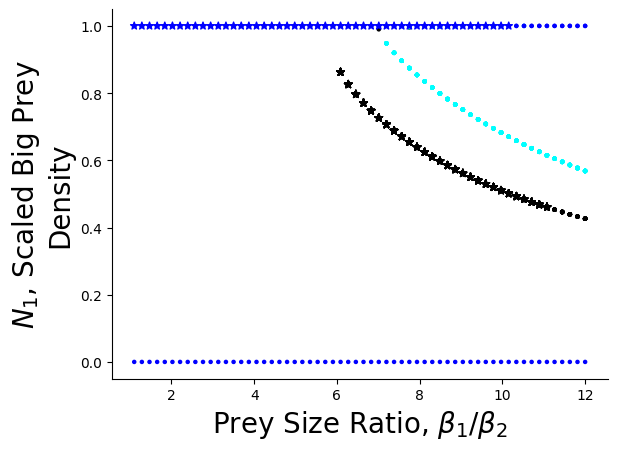

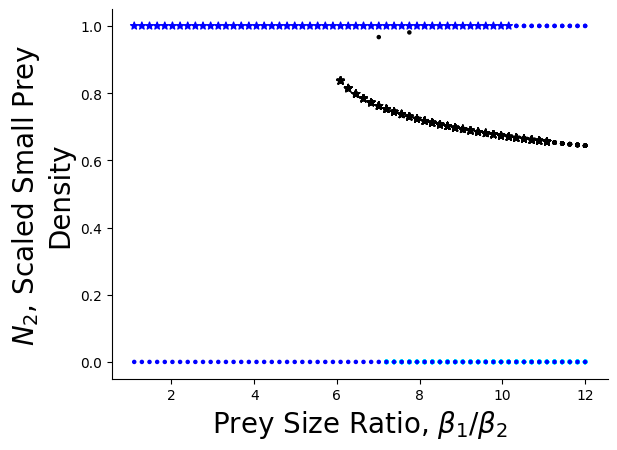

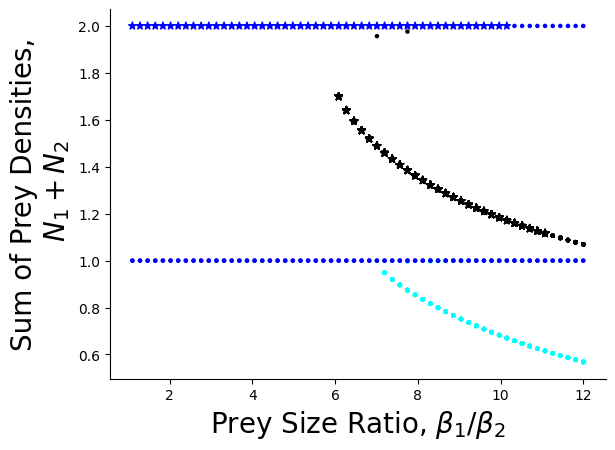

In [54]:

figx, figN1, figN2, figNsum = plot_bif_diagram(stable_points, unstable_points, 
                                      xlab = "Prey Size Ratio, " + r'$\beta_1/\beta_2$')


Signature: update_params(param_key, param, params_base)
Docstring: <no docstring>
File:      /var/folders/_4/t51wvvv53c35d1q0pv8mywxr0000gq/T/ipykernel_88423/154444673.py
Type:      function

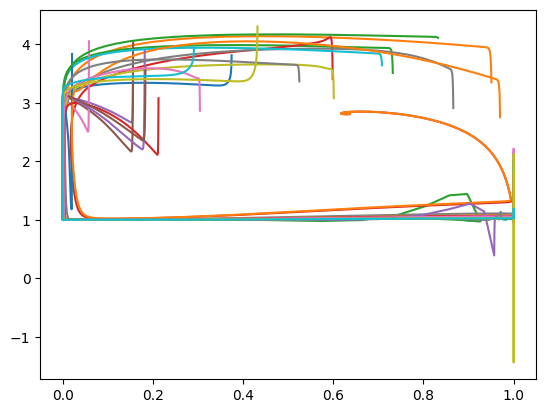

In [4]:
t_f = 1000
trajectories = []

params = update_params("scale", 8, params_base)
initial_pts = get_initial_points(20,**params.copy())
for i, init_state in enumerate(initial_pts):
    out2 = solve_ivp(full_model, [0, t_f], init_state, 
                         method = "LSODA", args = (True, params))
    results  = get_results(out2, x_max) 
    T, N1, N2, P, g_of_x_vec, mean_x = results
    plt.plot(N1, mean_x)
    trajectories.append(results)
    

In [8]:
get_equilibria_from_init_pts(initial_pts,**params)

[]

In [12]:
results = []


for i, point in enumerate(initial_pts):
    out = get_equilibrium(params, N1_0 = point[0], N2_0 = point[1], g_of_x_vec = point[2:])

    # get the equilibrium values from the output
    sol = get_results_eq(out, x_max, tol = 1e-8)
    P_eq, N1_eq, N2_eq, g_eq, mean_x_eq, success = sol 
    
    if success: # the root finder found an equilibrium and it's "valid" (N1, N2, g(x) are in their ranges)
        new_eq = np.array([N1_eq, N2_eq, *g_eq, mean_x_eq])
        #results.append(new_eq)
        ## append new_eq if it's unique from previous ones found
        if len(results)>0:
            for result in results:
                if np.any(np.abs(new_eq - result) > 1e-8):
                    results.append(new_eq)
        else:
            results.append(new_eq)
print(results)
                # curr_eq = new_eq

[array([0.6340475 , 0.72130594, 0.23320018, 0.15116554, 0.20782921,
       0.08853843, 0.01187339, 2.81186875])]


In [57]:
for i, traj in enumerate(trajectories):
    T, N1, N2, P, g_of_x_vec, mean_x = traj
    if np.any(mean_x <0) or np.any(np.isnan(mean_x)):
        print(i)

0
9
12
18


In [59]:
np.where(np.isnan(trajectories[9][-1]))

(array([298, 299, 300]),)